Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# Load libraries

import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

In [2]:
# Load data

df = pd.read_csv('/datasets/car_data.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [3]:
# Examine the df dataframe

display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-05-04 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:00,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:00
354365,2016-03-14 17:48:00,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-06-04 00:46:00
354366,2016-05-03 19:56:00,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-05-03,0,26135,2016-11-03 18:17:00
354367,2016-03-19 18:57:00,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-07-04 07:15:00


In [4]:
# Examine df columns

for col in df:
    display(df[col].describe())

count                  354369
unique                  15470
top       2016-05-03 14:25:00
freq                       66
first     2016-01-04 00:06:00
last      2016-12-03 23:59:00
Name: DateCrawled, dtype: object

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

count     316879
unique         8
top        sedan
freq       91457
Name: VehicleType, dtype: object

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

count     334536
unique         2
top       manual
freq      268251
Name: Gearbox, dtype: object

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

count     334664
unique       250
top         golf
freq       29232
Name: Model, dtype: object

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Mileage, dtype: float64

count    354369.000000
mean          5.714645
std           3.726421
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

count     321474
unique         7
top       petrol
freq      216352
Name: FuelType, dtype: object

count         354369
unique            40
top       volkswagen
freq           77013
Name: Brand, dtype: object

count     283215
unique         2
top           no
freq      247161
Name: NotRepaired, dtype: object

count                  354369
unique                    109
top       2016-03-04 00:00:00
freq                    13719
first     2014-10-03 00:00:00
last      2016-12-03 00:00:00
Name: DateCreated, dtype: object

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

count    354369.000000
mean      50508.689087
std       25783.096248
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

count                  354369
unique                  18592
top       2016-07-04 07:16:00
freq                      654
first     2016-01-04 00:15:00
last      2016-12-03 23:54:00
Name: LastSeen, dtype: object

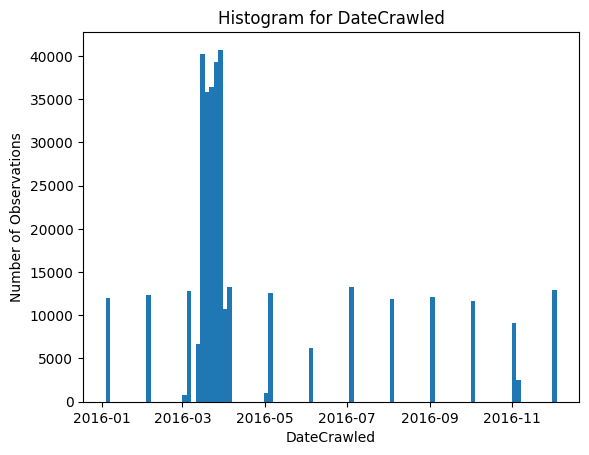

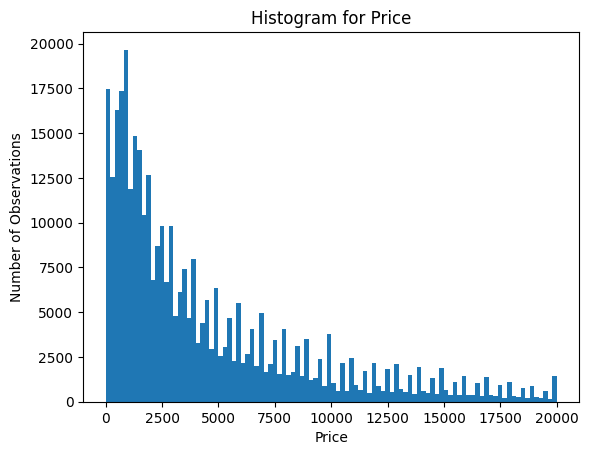

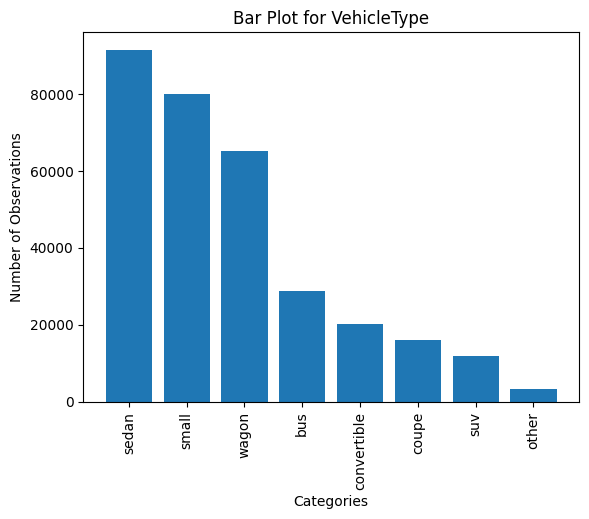

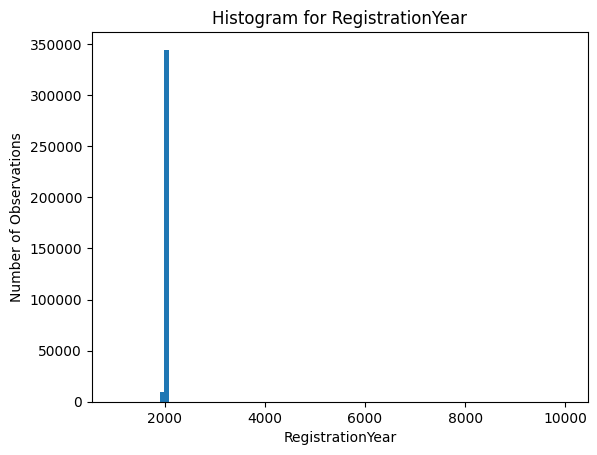

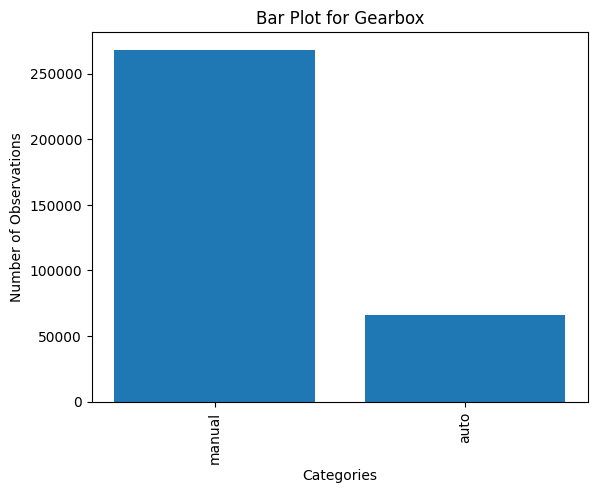

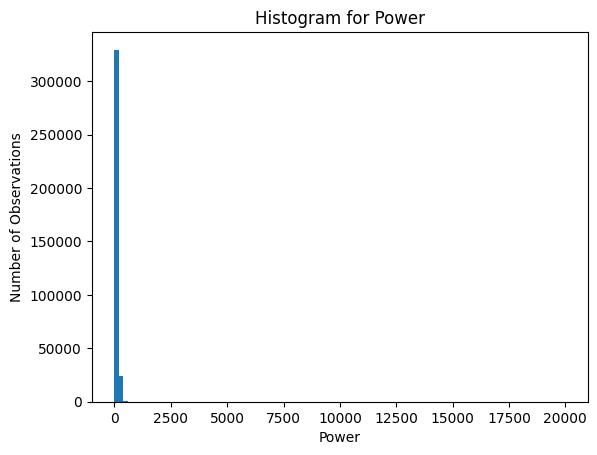

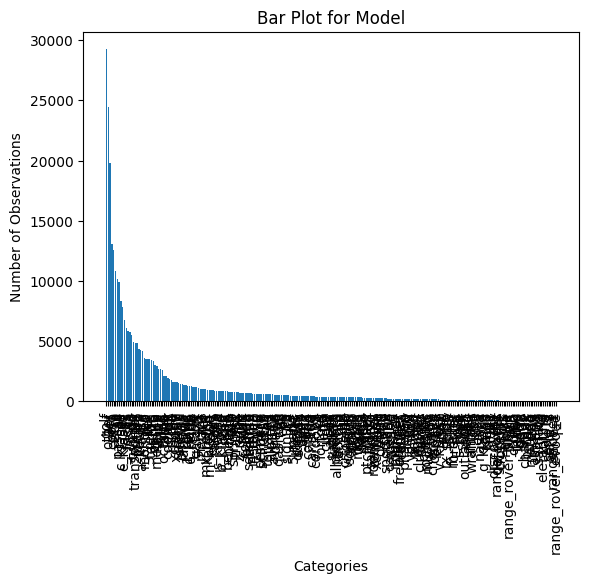

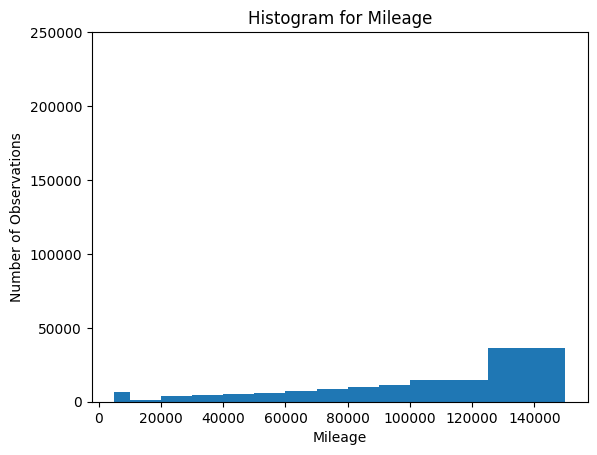

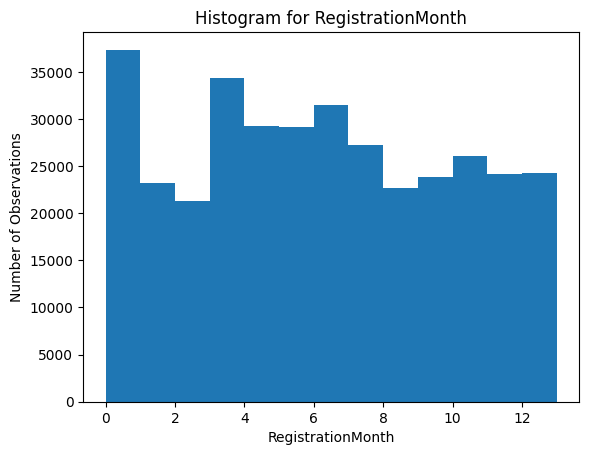

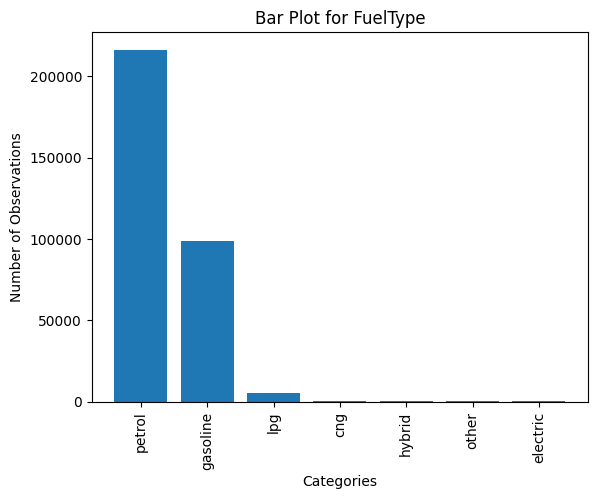

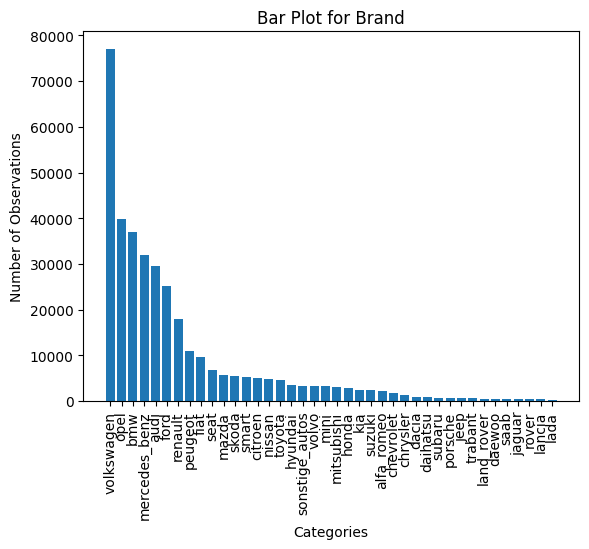

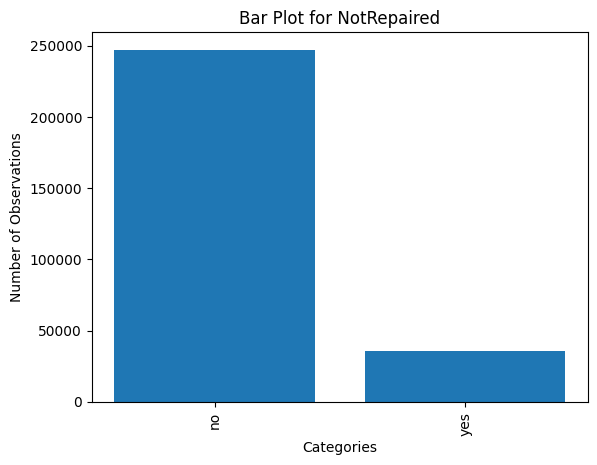

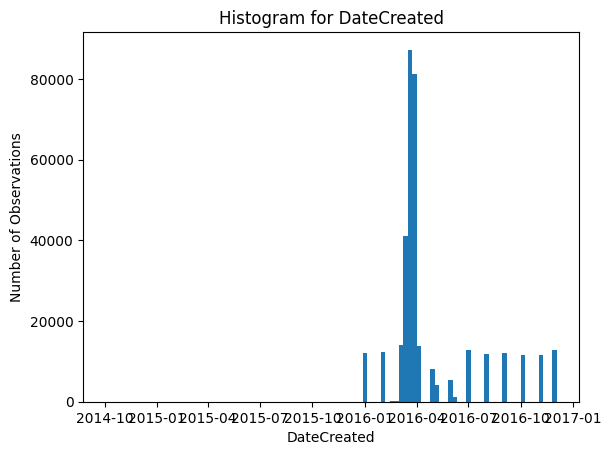

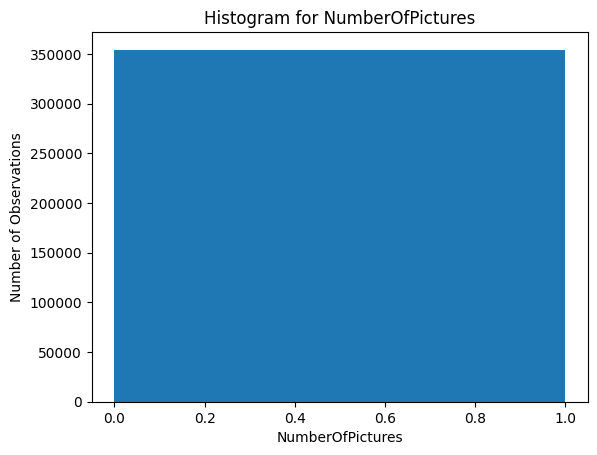

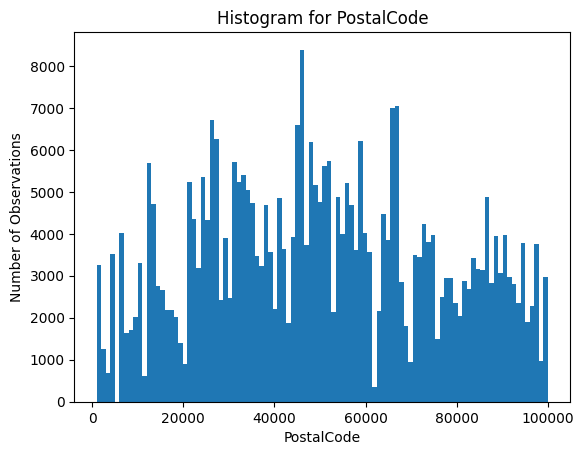

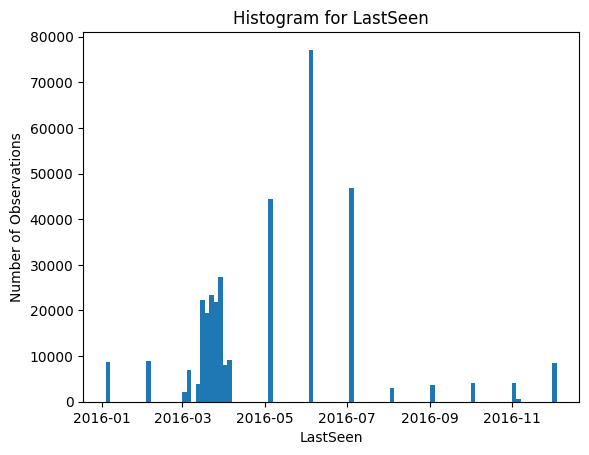

In [5]:
# Create a function to examine column distributions
# Plot each df column

def plots(df, column):
    if df[column].dtype == 'O':
        counts = df[column].value_counts()
        plt.bar(counts.index, counts.values) 
        plt.xlabel('Categories')
        plt.ylabel('Number of Observations')
        plt.title(f"Bar Plot for {column}")
        plt.xticks(rotation=90)
        plt.show()
    else:
        unique_values = np.sort(df[column].unique())
        if (len(unique_values) < 100): 
            bins = np.append(unique_values, unique_values[-1] + 1) 
        else: 
            bins = 100

        plt.hist(df[column], bins=bins)
        plt.xlabel(column)
        plt.ylabel('Number of Observations')
        plt.title(f'Histogram for {column}')
        plt.show()

for col in df:
    plots(df, col)

In [6]:
# Examine extreme values in the RegistrationYear column

registration_levels = [-1900, -1950, -1980, -2000, 2016]

for level in registration_levels:
    if level < 0:
        count = len(df[df['RegistrationYear'] < -level])
        print(f"RegistrationYear < {-level}: {count} ({100*count/len(df):.2f}%)")
    else:
        count = len(df[df['RegistrationYear'] > level])
        print(f"RegistrationYear > {level}: {count} ({100*count/len(df):.2f}%)")

RegistrationYear < 1900: 66 (0.02%)
RegistrationYear < 1950: 246 (0.07%)
RegistrationYear < 1980: 3452 (0.97%)
RegistrationYear < 2000: 102253 (28.85%)
RegistrationYear > 2016: 14530 (4.10%)


In [7]:
# Examine extreme values in the Power column

power_levels = [-1, -50, -100, 200, 500, 1500]

for level in power_levels:
    if level < 0:
        count = len(df[df['Power'] < -level])
        print(f"Power < {-level}: {count} ({100*count/len(df):.2f}%)")
    else:
        count = len(df[df['Power'] > level])
        print(f"Power > {level}: {count} ({100*count/len(df):.2f}%)")

Power < 1: 40225 (11.35%)
Power < 50: 46172 (13.03%)
Power < 100: 154267 (43.53%)
Power > 200: 22893 (6.46%)
Power > 500: 459 (0.13%)
Power > 1500: 203 (0.06%)


In [8]:
# Examine values for the RegistrationMonth column

pd.DataFrame({'count': df['RegistrationMonth'].value_counts(), 'normalized': df['RegistrationMonth'].value_counts(normalize=True)}).sort_index()

,count,normalized
0,37352,0.105404
1,23219,0.065522
2,21267,0.060014
3,34373,0.096998
4,29270,0.082598
5,29153,0.082267
6,31508,0.088913
7,27213,0.076793
8,22627,0.063852
9,23813,0.067198


In [9]:
# Examine extreme values in the DateCreated column

df['DateCreated'].sort_values().head(30)

61207    2014-10-03
9972     2015-02-11
4001     2015-03-20
221002   2015-04-09
75598    2015-04-09
260635   2015-05-12
226822   2015-05-12
85505    2015-05-12
29712    2015-06-12
342275   2015-06-18
86601    2015-07-08
161567   2015-08-11
340616   2015-09-09
175103   2015-10-08
282938   2015-10-11
60168    2015-11-17
153650   2015-11-23
301180   2015-11-23
125286   2015-11-24
77378    2015-11-24
75684    2015-12-11
274600   2015-12-17
76459    2015-12-27
343447   2015-12-30
344287   2015-12-30
244633   2015-12-30
282006   2016-01-02
247299   2016-01-02
293917   2016-01-02
161159   2016-01-03
Name: DateCreated, dtype: datetime64[ns]

In [10]:
# Examine extreme values in the PostalCode column

postal_levels = [-501, -10000, 99950]

for level in postal_levels:
    if level < 0:
        count = len(df[df['PostalCode'] < -level])
        print(f"PostalCode < {-level}: {count} ({100*count/len(df):.2f}%)")
    else:
        count = len(df[df['PostalCode'] > level])
        print(f"PostalCode > {level}: {count} ({100*count/len(df):.2f}%)")

PostalCode < 501: 0 (0.00%)
PostalCode < 10000: 18159 (5.12%)
PostalCode > 99950: 275 (0.08%)


In [11]:
# Examine missing values in all columns

display(df.isna().sum())

missing_any = df.isna().any(axis=1).sum()
print(f"Rows missing any values: {missing_any} ({100*missing_any/len(df):.2f}%)")

numeric_cols = ['DateCrawled', 'Price', 'RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth', 'DateCreated', 'LastSeen']
missing_num = df[numeric_cols].isna().any(axis=1).sum()
print(f"Rows missing any numeric values: {missing_num} ({100*missing_num/len(df):.2f}%)")

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Rows missing any values: 108555 (30.63%)
Rows missing any numeric values: 0 (0.00%)


The data look good overall. Most of the distributions are skewed or have noticeable class imbalances, but not enough to threaten model integrity. Especially because I will be focusing on non-linear models, none but the most drastic distributional issues are a cause for concern. Even so, several features are problematic in various ways. 

The RegistrationYear column has some questionable data, including impossible years as low as 1000 and as high as 9999. Fewer than 1% of the listings have values below 1980 but consumer cars have existed since probably around 1900 (Ford's Model A debuted in 1903 and others were earlier), so values as low as that are plausible. Based on the DateCrawled, DateCreated, and LastSeen columns, these data were all created in 2016, so RegistrationYear values later than that seem inappropriate. I will assume the 66 listings with values below 1900 and the 14,530 listings (4.1% of the data) above 2016 are errors of some kind and clip the data by replacing low values with 1900 and high values with 2016. 

The Power column is a problem. Based on cursory online research, the average consumer car has around 200 horsepower with few below 100 (none below 50) and few above 500 (none above 1,500). Around 13% of the Power column listings are below 50 (with 11% equal to 0), and 0.06% are greater than 1,500 (with some as high as 20,000). It is possible that 0 horsepower indicates an inoperable vehicle being sold for parts and I suppose the listing with 20,000 horsepower could have a custom jet engine. However it seems at least as likely that 0 indicates missing data and the other outliers are data entry or other errors. They might also be measuring horsepower in an unusual way. Without more information, I cannot say for sure. Because the extreme values are not just unusual but impossible (assuming this is a conventional measure of horsepower), I will avoid the undue influence of outliers by clipping the data. With an average Power value of 110, much lower than my estimate from external sources, this dataset trends low. Bearing that in mind, I will replace the 46,172 values (13% of the data, <2% of the non-zero data) below 50 with 50 and the 459 listings (0.13% of the data) above 500 with 500. 

The RegistrationMonth column has 13 unique values (0-12) despite there being only 12 months. I assume the 37,352 listings (10.5% of the data) with values of 0 represent missing data. I do not want to leave them as they are because RegistrationMonth is an ordinal feature, so 0 implies a value earlier than January. I will replace 0s with the median value and add a new binary feature called RegMonthMissing to indicate listings that originally had 0s for RegistrationMonth. 

The DateCreated column mostly has listings from 2016, but there are also 25 from 2015 and 1 from 2014. I think those are all plausible values and will leave them in place.

The NumberOfPictures column is worthless because every listing has a value of 0. Evidently, none of the historical data included pictures. I will drop the column because it contains no information. 

The PostalCode column has some confusing data. ZIP codes in the United States always have five digits, but 18,159 listings (5.1% of the dataset) have values less than 10,000 and thus fewer than five digits. I think those values are supposed to have leading 0s that were lost because the data were treated as integers instead of strings. I will change the data type to string and add leading 0s where appropriate. ZIP codes should be represented as strings anyway because they are nominal data, neither continuous nor even ordinal. As far as I can tell, ZIP codes range from 00501 to 99950, which calls into question 225 listings with PostalCode values greater than that (as high as 99998). Those errant values could come from outside the US or be data entry errors. There are very few such listings and they pose no threat as outliers so I will just ignore them.

A fairly large proportion of the listings (31%) are missing data for one or more features. Only categorical features are missing data, which is fortunate because the models can treat missing values as a separate category. No imputation or dropping is necessary. To make sure they are processed appropriately, I will replace missing values with the value "missing."

In [12]:
# Clip values < 1900 and > 2016 in the RegistrationYear column

df['RegistrationYear'] = df['RegistrationYear'].clip(lower=1900, upper=2016)

df['RegistrationYear'].describe()

count    354369.000000
mean       2003.017397
std           7.574679
min        1900.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [13]:
# Clip values < 50 and > 500 in the Power column

df['Power'] = df['Power'].clip(lower=50, upper=500)

df['Power'].describe()

count    354369.000000
mean        112.747478
std          56.532627
min          50.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         500.000000
Name: Power, dtype: float64

In [14]:
# Create a new column to indicate listings with RegistrationMonth = 0
# Change zeros in the RegistrationMonth column to the median value

df['RegMonthMissing'] = (df['RegistrationMonth'] == 0).astype(int)
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = df.loc[df['RegistrationMonth'] > 0, 'RegistrationMonth'].median()

In [15]:
# Drop the NumberOfPictures column 

df = df.drop('NumberOfPictures', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  float64       
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

In [16]:
# Fix the PostalCode column by converting to string data type and adding leading zeros

df['PostalCode'] = df['PostalCode'].astype(str)
df.loc[df['PostalCode'].str.len() == 4, 'PostalCode'] = '0' + df['PostalCode']

display(df['PostalCode'])
df['PostalCode'].str.len().value_counts().sort_index()

0         70435
1         66954
2         90480
3         91074
4         60437
          ...  
354364    02694
354365    39576
354366    26135
354367    87439
354368    40764
Name: PostalCode, Length: 354369, dtype: object

5    354369
Name: PostalCode, dtype: int64

In [17]:
# Replace missing values with the value 'missing'

df = df.fillna('missing')

df.isnull().sum().sum()

0

In [18]:
# Check the number of categories in each column

for col in df:
    print(col,df[col].dtype, len(df[col].unique()))

DateCrawled datetime64[ns] 15470
Price int64 3731
VehicleType object 9
RegistrationYear int64 96
Gearbox object 3
Power int64 363
Model object 251
Mileage int64 13
RegistrationMonth float64 12
FuelType object 8
Brand object 40
NotRepaired object 3
DateCreated datetime64[ns] 109
PostalCode object 8143
LastSeen datetime64[ns] 18592
RegMonthMissing int64 2


Linear regression and random forest regression require categorical data to be properly encoded. Several categories of features need to be encoded in different ways. 

The Price, Power, Mileage, RegistrationMonth, and RegistrationYear features are numeric and require no further encoding or scaling. 

The DateCrawled, DateCreated, and LastSeen features have complex datetime64[ns] data types that are not easily processed by models. It is often best to extract useful components of datetime data such as year, month, day, season, etc. I suspect those particular features related to website usage instead of vehicle information are of little value for this project and I would prefer to avoid adding too many extraneous features. I will recode the timestamps as the number of days since the earliest date in the dataset. That preserves the trendline data at a reasonable level of specificity without adding any features. 

The VehicleType, Gearbox, FuelType, NotRepaired, and RegMonthMissing features each have fewer than 10 unique categories, making it practical to encode each category as a binary feature. I will use One Hot Encoding to accomplish that, adding 19 new features in the process. 

The Model, Brand, and PostalCode variables each have large numbers of categories ranging from 40 to 8,143. OHE is not a viable option because it would add an onerous number of new features. An alternative method of handling categorical data with high cardinality is target encoding. It replaces each categorical value in the feature with the mean value of the target for that category. If vehicle model provides useful information about prices, replacing each model with its average price should retain much of that information while transforming it into a much more manageable numeric feature. I will implement target encoding with the category_encoders library. Because this is an external library not included in the backend, I need to install it before loading and using it. 

The LGBMRegressor and CatBoostRegressor models can natively handle categorical features, but I will use the encoded data for all model training instead of keeping track of separate dataframes. That will also enable a better comparison between the various models. 

In [19]:
# Install and load category_encoders library for target coding

import sys
!{sys.executable} -m pip install category_encoders

import category_encoders as ce

In [20]:
# Encode categorical and timedate columns

ohe_cols = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
targ_cols = ['Model', 'Brand', 'PostalCode']
datetime_cols = ["DateCrawled", "DateCreated", "LastSeen"]

target_encoder = ce.TargetEncoder(cols=targ_cols)
df[targ_cols] = target_encoder.fit_transform(df[targ_cols], df['Price'])

df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)

for col in datetime_cols:
    df[col] = (df[col] - df[col].min()).dt.days

In [21]:
# Check df to confirm encoding success

display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   DateCrawled              354369 non-null  int64  
 1   Price                    354369 non-null  int64  
 2   RegistrationYear         354369 non-null  int64  
 3   Power                    354369 non-null  int64  
 4   Model                    354369 non-null  float64
 5   Mileage                  354369 non-null  int64  
 6   RegistrationMonth        354369 non-null  float64
 7   Brand                    354369 non-null  float64
 8   DateCreated              354369 non-null  int64  
 9   PostalCode               354369 non-null  float64
 10  LastSeen                 354369 non-null  int64  
 11  RegMonthMissing          354369 non-null  int64  
 12  VehicleType_convertible  354369 non-null  uint8  
 13  VehicleType_coupe        354369 non-null  uint8  
 14  Vehi

None

,DateCrawled,Price,RegistrationYear,Power,Model,Mileage,RegistrationMonth,Brand,DateCreated,PostalCode,...,Gearbox_missing,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_missing,FuelType_other,FuelType_petrol,NotRepaired_no,NotRepaired_yes
0,80,480,1993,50,4154.306856,150000,6.0,4381.277070,538,4733.064777,...,0,0,0,0,0,0,0,1,0,0
1,80,18300,2011,190,2927.355037,125000,5.0,6239.976507,538,3905.046663,...,0,0,1,0,0,0,0,0,0,1
2,70,9800,2004,163,6383.393939,125000,8.0,7065.096012,528,5088.585323,...,0,0,1,0,0,0,0,0,0,0
3,73,1500,2001,75,4154.306856,150000,6.0,4381.277070,531,5196.530240,...,0,0,0,0,0,0,0,1,1,0
4,87,3600,2008,69,4183.921635,90000,7.0,5909.606727,545,5493.293815,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,77,0,2005,50,2360.266974,150000,7.0,2932.187624,535,2864.384105,...,0,0,0,0,0,0,0,1,0,1
354365,70,2200,2005,50,2927.355037,20000,1.0,5026.058684,528,3507.096184,...,1,0,0,0,0,1,0,0,0,0
354366,120,1199,2000,101,3596.747060,125000,3.0,3487.832634,578,4167.916744,...,0,0,0,0,0,0,0,1,1,0
354367,75,9200,1996,102,6714.598299,150000,3.0,4381.277070,533,4874.919149,...,0,0,1,0,0,0,0,0,1,0


In [22]:
# Split the data into training and test sets

features = df.drop('Price', axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

print(f"Training set size: {len(features_train)}, {100*len(features_train)/len(df):.0f}%")
print(f"Test set size: {len(features_test)}, {100*len(features_test)/len(df):.0f}%")

Training set size: 265776, 75%
Test set size: 88593, 25%


## Model training

In [23]:
# Create a function to plot random hyperparameter search results

def plot_search(results, params):
    results_df = pd.DataFrame(results)
    results_df = results_df[[f"param_{x}" for x in params] + ['mean_test_score']]
    results_df['mean_test_score'] = -results_df['mean_test_score']

    i = 0
    plt.figure(figsize=(12, 5))
    for param in params:
        i += 1
        plt.subplot(1, 3, i)
        results_df.groupby(f"param_{param}")['mean_test_score'].mean().plot(marker='o')
        plt.xlabel(param)
        plt.ylabel("Average RMSE")
        plt.title(f"Average RMSE by {param}")

    plt.tight_layout()
    plt.show()
    
    return results_df.sort_values(by='mean_test_score')

In [24]:
%%time
# Search hyperparameters to optimize random forest regressor performance

param_grid = {
    'n_estimators': [5, 10, 15, 25, 50],
    'max_depth': [5, 10, 15, 20, 25]
}

model = RandomForestRegressor(random_state=12345)
random_search = RandomizedSearchCV(model, param_grid, random_state=12345, n_iter=25, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
random_search.fit(features_train, target_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (RMSE):", -random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'max_depth': 25}
Best Score (RMSE): 1739.4838016625556
CPU times: user 19min 35s, sys: 5.18 s, total: 19min 40s
Wall time: 19min 41s


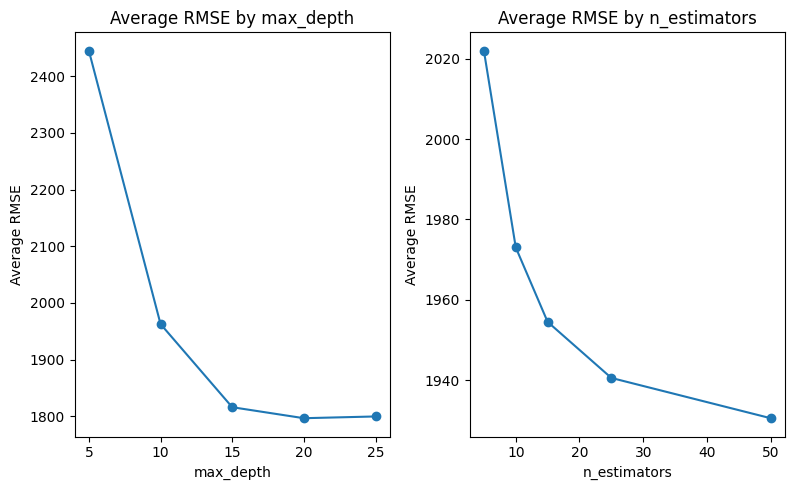

,param_max_depth,param_n_estimators,mean_test_score
24,25,50,1739.483802
19,20,50,1743.423856
23,25,25,1757.863524
18,20,25,1759.829271
14,15,50,1780.668356
17,20,15,1782.226492
22,25,15,1783.394119
13,15,25,1791.348519
12,15,15,1806.448398
16,20,10,1810.068426


In [25]:
# Plot results of hyperparameter search

plot_search(random_search.cv_results_, ['max_depth', 'n_estimators'])

In [26]:
%%time
# Search hyperparameters to optimize LGBM gradient boosted decision tree regressor performance

param_grid = {
    'n_estimators': [5, 10, 15, 25, 50],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.20]
}

model = LGBMRegressor(random_state=12345, metric='rmse')
random_search = RandomizedSearchCV(model, param_grid, n_iter=50, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
random_search.fit(features_train, target_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (RMSE):", -random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.2}
Best Score (RMSE): 1801.978031998029
CPU times: user 3min 3s, sys: 3.22 s, total: 3min 6s
Wall time: 3min 6s


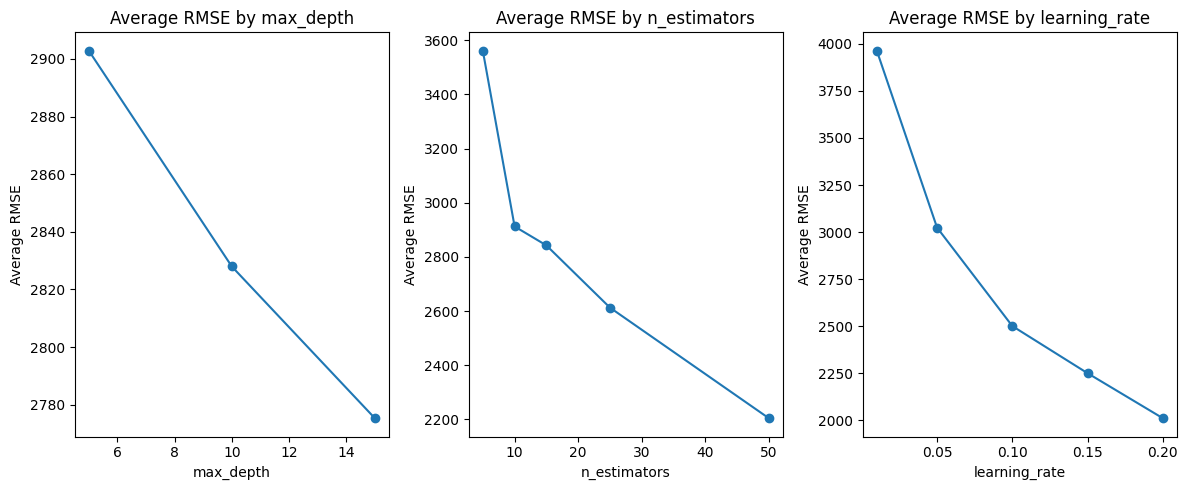

,param_max_depth,param_n_estimators,param_learning_rate,mean_test_score
10,15,50,0.2,1801.978032
36,10,50,0.2,1803.424739
38,15,50,0.15,1823.342193
45,15,50,0.1,1873.657651
48,10,50,0.1,1875.565702
32,15,25,0.2,1882.526779
19,10,25,0.2,1883.883843
6,5,25,0.2,1923.365533
37,5,50,0.1,1924.353668
23,5,25,0.15,1973.839810


In [27]:
# Plot results of hyperparameter search

plot_search(random_search.cv_results_, ['max_depth', 'n_estimators', 'learning_rate'])

In [28]:
%%time
# Search hyperparameters to optimize CatBoost gradient boosted decision tree regressor performance

param_grid = {
    'n_estimators': [5, 10, 15, 25, 50],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.20]
}

model = CatBoostRegressor(random_state=12345, loss_function='RMSE', verbose=0)
random_search = RandomizedSearchCV(model, param_grid, n_iter=50, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
random_search.fit(features_train, target_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (RMSE):", -random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.2}
Best Score (RMSE): 1758.66102960983
CPU times: user 10min 29s, sys: 4min 53s, total: 15min 23s
Wall time: 15min 36s


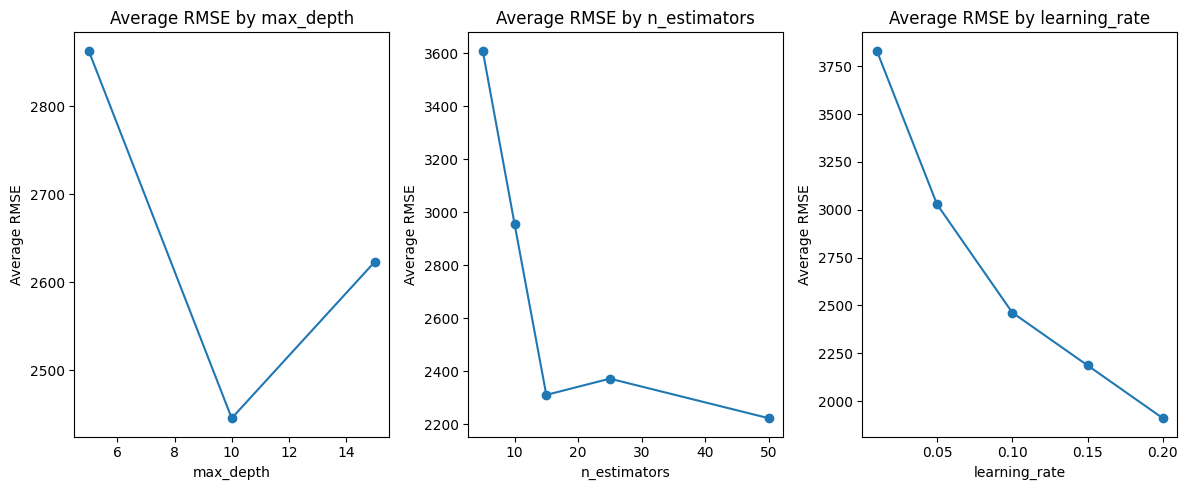

,param_max_depth,param_n_estimators,param_learning_rate,mean_test_score
2,15,50,0.2,1758.661030
16,15,50,0.15,1768.751384
49,10,50,0.2,1792.271506
36,15,50,0.1,1801.473592
34,10,50,0.15,1815.944486
25,15,25,0.15,1843.128613
14,10,50,0.1,1867.782508
4,10,25,0.2,1871.730041
46,15,15,0.2,1887.088519
21,10,25,0.15,1921.150857


In [29]:
# Plot results of hyperparameter search

plot_search(random_search.cv_results_, ['max_depth', 'n_estimators', 'learning_rate'])

I used RandomizedSearchCV to optimize hyperparameters and cross-validate models. It efficiently searches a hyperparameter space by randomly selecting hyperparameter combinations to train and identifying the best scoring model. I also plotted the results to get a better idea of how various hyperparameters affected model performance. 

The first model was a random forest regressor trained on a variety of values for hyperparameters n_estimators and max_depth. The best scoring model was the most complex one attempted (n_estimators = 50 and max_depth = 25; RMSE = 1739), but performance began to plateau with 25 estimators and max depth of 20 (RMSE = 1760). Further performance gains were probably outweighed by increased complexity. 

The next model was a gradient boosted decision tree regressor implemented with LGBM and trained on a variety of values for hyperparameters n_estimators, max_depth, and learning_rate. It also scored best with the most complex configuration (n_estimators = 50, max_depth = 15, and learning_rate = 0.20; RMSE = 1802) but showed decreasing marginal utility beyond 25 estimators, a max depth of 10, and a learning rate of 0.15 (RMSE = 1926). More estimators did improve performance noticeably but since this project places a high priority on efficiency, I think the added complexity outweighs those gains. 

The last model was a gradient boosted decision tree regressor implemented with CatBoost and trained on a variety of values for hyperparameters n_estimators, max_depth, and learning_rate. As with the others, it scored best with the most complex configuration (n_estimators = 50, max_depth = 15, and learning_rate = 0.20; RMSE = 1759) but showed decreasing marginal utility beyond 25 estimators, a max depth of 15 and a learning rate of 0.20; RMSE = 1808). More estimators did improve performance noticeably but since this project places a high priority on efficiency, I think the added complexity outweighs those gains. 

The time it took to optimize hyperparameters may not be entirely comparable across models because the hyperparameter spaces and settings were not identical, but I tried to keep them reasonably consistent. The gradient boosted models had an extra hyperparameter to optimize (learning_rate) but fewer options for max_depth because CatBoost has a limit of 16. I also used more search iterations (50 vs 25) for the gradient boosted models to better cover the larger hyperparameter space. It is worth noting that I limited the number of CPU cores used for parallel computation (via the n_jobs parameter) to eliminate some errors that occurred with all cores in play. That slowed down the hyperparameter search somewhat and may affect different algorithms in different ways. The times change each time code is run but I recorded them once for the purpose of discussion. Despite those caveats, I think some conclusions can be drawn.

The random forest regressor model had the slowest hyperparameter search (19 min, 41 sec), followed by CatBoost (15 min, 36 sec), and finally LGBM (3 min, 6 sec). It makes sense for the random forest model to take longer because it is more complex than decision tree models, though gradient boosting might offset that advantage somewhat. The much more dramatic difference was between gradient boosting models, with CatBoost taking about five times as long as LGBM! The LGBM implementation is known to be faster than CatBoost because it uses more efficient methods and precomputes some elements, but a 5x difference is astonishing. 

## Model analysis

In [30]:
# Train a linear regression model as a sanity check

model = LinearRegression()
%time model.fit(features_train, target_train)
%time predictions = pd.Series(model.predict(features_test))
rmse = mean_squared_error(target_test, predictions) ** 0.5

print('Linear Regression Model')
print(f'Test RMSE: {rmse:.2f}')

CPU times: user 232 ms, sys: 71.1 ms, total: 303 ms
Wall time: 299 ms
CPU times: user 9.45 ms, sys: 24.2 ms, total: 33.7 ms
Wall time: 8.59 ms
Linear Regression Model
Test RMSE: 2844.67


In [31]:
# Train the best random forest regressor model

model = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth=20)
%time model.fit(features_train, target_train)
%time predictions = pd.Series(model.predict(features_test))
rmse = mean_squared_error(target_test, predictions) ** 0.5

print('Random Forest Regressor Model')
print('Parameters: n_estimators=25, max_depth=20')
print(f'Test RMSE: {rmse:.2f}')

CPU times: user 34.9 s, sys: 138 ms, total: 35 s
Wall time: 35 s
CPU times: user 540 ms, sys: 4 ms, total: 544 ms
Wall time: 547 ms
Random Forest Regressor Model
Parameters: n_estimators=25, max_depth=20
Test RMSE: 1718.19


In [32]:
# Train the best gradient boosted decision tree regressor model with LGBM 

model = LGBMRegressor(random_state=12345, metric='rmse', n_estimators=25, max_depth=10, learning_rate=0.15)
%time model.fit(features_train, target_train)
%time predictions = pd.Series(model.predict(features_test))
rmse = mean_squared_error(target_test, predictions) ** 0.5

print('Gradient Boosted Decision Tree Model (with LGBM)')
print('Parameters: n_estimators=25, max_depth=10, learning_rate=0.15')
print(f'Test RMSE: {rmse:.2f}')

CPU times: user 1.55 s, sys: 7.69 ms, total: 1.55 s
Wall time: 1.53 s
CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 192 ms
Gradient Boosted Decision Tree Model (with LGBM)
Parameters: n_estimators=25, max_depth=10, learning_rate=0.15
Test RMSE: 1928.81


In [33]:
# Train the best gradient boosted decision tree regressor model with CatBoost

model = CatBoostRegressor(random_state=12345, loss_function='RMSE', n_estimators=25, max_depth=15, learning_rate=0.2)
%time model.fit(features_train, target_train, verbose=0)
%time predictions = pd.Series(model.predict(features_test))
rmse = mean_squared_error(target_test, predictions) ** 0.5

print('Gradient Boosted Decision Tree Model (with CatBoost)')
print('Parameters: n_estimators=25, max_depth=15, learning_rate=0.2')
print(f'Test RMSE: {rmse:.2f}')

CPU times: user 11.4 s, sys: 5.55 s, total: 17 s
Wall time: 17.1 s
CPU times: user 15.5 ms, sys: 3.33 ms, total: 18.8 ms
Wall time: 18.6 ms
Gradient Boosted Decision Tree Model (with CatBoost)
Parameters: n_estimators=25, max_depth=15, learning_rate=0.2
Test RMSE: 1783.85


In [34]:
# Display results of model testing

test_results = pd.DataFrame({
'model': ['LR', 'RF', 'DT (LGBM)', 'DT (CB)'],
'score': [2844.67, 1718.19, 1928.81, 1783.85],
'train time': [261, 33900, 1690, 17500],
'run time': [5, 511, 186, 16]
})

test_results.reset_index(drop=True).sort_values(by='score')

,model,score,train time,run time
1,RF,1718.19,33900,511
3,DT (CB),1783.85,17500,16
2,DT (LGBM),1928.81,1690,186
0,LR,2844.67,261,5


I tested the random forest regressor model, both implementations of gradient boosted decision tree regressor models, and a linear regression model as a sanity check. The time it took to train the models and make predictions differed somewhat each time the code was run, but they tended to be fairly consistent. I recorded and displayed the durations in milliseconds from one particular run for the purpose of discussing them. 

The random forest regressor model scored best with an RMSE of 1718, followed by the CatBoost model with an RMSE of 1784, the LGBM model with an RMSE of 1929, and finally the linear regression model with an RMSE of 2845. All three substantive models outperformed the linear regression, passing the sanity check. It is perhaps not surprising that the random forest model outperformed the decision tree models because it is somewhat more complex. 

Training time was inversely proportional to test score such that the best scoring models took the longest to train. The linear regression (261 ms) trained an order of magnitude faster than the LGBM decision tree (1,690 ms), which trained another order of magnitude faster than the CatBoost decision tree (17,500 ms), which was twice as fast as the random forest (33,900 ms). 

The order of prediction time was slightly different. The linear regression (5 ms) ran three times as fast as the CatBoost decision tree (16 ms), which was an order of magnitude faster than the LGBM decision tree (186 ms), which was 2.7 times as fast as the random forest (511 ms).

In sum, the random forest model was the best performing model but the slowest to train and the second slowest to make predictions. The linear regression model was the worst performing model but the fastest to train and make predictions. The decision tree models were intermediate, with the CatBoost model performing quite well and making quick predictions but taking fairly long to train. The LGBM model scored somewhat worse than CatBoost and took moderately longer to make predictions but trained much faster. The best model depends on how those three factors (score, training time, and prediction time) are prioritized. If I had to choose one, I would select the CatBoost decision tree regressor model because it is both fast and accurate at making predictions without taking an unreasonable time to train. Especially since training should only need to occur once, I think it best balances the three factors.

## Conclusion

The purpose of this project was to train a model to predict car values from historical data for the Rusty Bargain used car sales service. I did that by preparing the data for modeling, training several models, and comparing their speed and quality. 

The data provided were suitable for modeling but required significant preparation. Questionable or outright impossible values for RegistrationYear, Power, RegistrationMonth, and PostalCode features needed to be trimmed or recoded and the NumberOfPictures feature was dropped altogether because it provided no useful information. A large number of missing values in categorical features were recoded so they could be included in the models as separate categories. 

Although LGBM and CatBoost gradient boosting implementations deal with categorical features natively, the data needed to be further encoded for the linear and random forest regression models to run properly. Features with datetime data types were recoded to the number of days since the earliest date in the dataset because raw timestamps are not handled well. Categorical features with fewer than 10 unique categories were subjected to One Hot Encoding but doing so for features with many categories was impractical. Instead, target encoding replaced categorical values with the mean value for each category. In the end, the dataset contained 31 properly encoded features, a manageable number for modeling purposes. All models were trained on the encoded data for simplicity and consistency. 

Using RandomizedSearchCV to search for optimal hyperparameters, I explored a relatively constrained hyperparameter space to avoid excessive training times. Several values of the n_estimators and max_depth hyperparameters were tried for all models and several values of learning_rate were added for the gradient boosted models. All models performed best with the most complex hyperparameter configurations attempted, but simpler configurations offered reasonable performance. Because this project is concerned with efficiency as well as scores, I chose hyperparameters that balanced between those factors. The final model specifications were as follows: random forest regressor (n_estimators = 25, max_depth = 20; RMSE = 1760), LGBM decision tree regressor (n_estimators = 25, max_depth = 10, and learning_rate = 0.15; RMSE = 1926), CatBoost decision tree regressor (n_estimators = 25, max_depth = 15, and learning_rate = 0.20; RMSE = 1808). The random forest model was the best scoring during training but it took almost 20 minutes to optimize hyperparameters, followed by CatBoost at almost 16 minutes, and LGBM at 3 minutes.

Finally, I tested all three models against a linear regression model as a sanity check. The random forest regressor scored best (RMSE = 1718), followed by CatBoost (RMSE = 1784), LGBM (RMSE = 1929), and linear regression (RMSE = 2845). The linear regression model was the fastest to train (261 ms), followed by LGBM (1,690 ms), CatBoost (17,500 ms), and the random forest regressor (33,900 ms). The linear regression model was also the fastest to make predictions (5 ms), followed by CatBoost (16 ms), LGBM (186 ms), and the random forest regressor (511). The best model depends on which attribute is most valued. The random forest scored best, the linear regression ran fastest, and the two gradient boosted decision trees balanced both considerations, with CatBoost scoring better and predicting faster than LGBM but taking longer to train. 

I recommend that Rusty Bargain implement a version of the CatBoost decision tree regressor model. It offers the best balance of performance, providing reasonably fast and accurate predictions. It trains somewhat sluggishly but since that only needs to be done once, it should have no effect on the final product. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed